In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# 1. Load dữ liệu và xử lý thời gian
train_df = pd.read_csv("btc_train.csv", parse_dates=['Date'], index_col='Date')
val_df = pd.read_csv("btc_val.csv", parse_dates=['Date'], index_col='Date')
test_df = pd.read_csv("btc_test.csv", parse_dates=['Date'], index_col='Date')


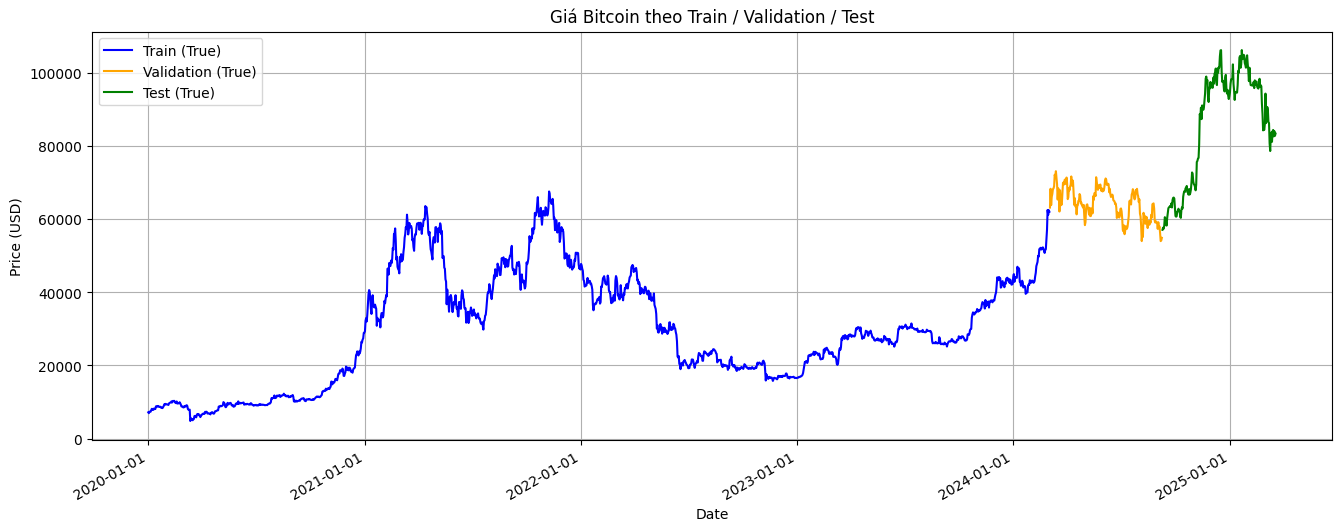

In [ ]:
# 1. Tạo một Series đầy đủ từ 3 phần
full_prices = pd.concat([
    train_df['Price'],
    val_df['Price'],
    test_df['Price']
])

# 2. Tạo đồ thị, vẽ lần lượt từng phần với màu khác nhau
plt.figure(figsize=(16,6))

plt.plot(train_df.index, train_df['Price'], label='Train (True)', color='blue')
plt.plot(val_df.index, val_df['Price'], label='Validation (True)', color='orange')
plt.plot(test_df.index, test_df['Price'], label='Test (True)', color='green')

# 3. Định dạng trục x ngày tháng
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.title('Giá Bitcoin theo Train / Validation / Test')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 2. Chọn cột cần thiết và scale
feature_cols = ['Open', 'High', 'Low', 'Vol.', 'Price']
train_df = train_df[feature_cols]
val_df = val_df[feature_cols]
test_df = test_df[feature_cols]

In [ ]:
# 3. Chuẩn hóa dữ liệu
scaler = StandardScaler()
# fit: tính trung bình và độ lệch chuẩn từ train_df.
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)       # chỉ áp dụng transform ở tập val và tập test tránh bị rò rỉ dữ liệu
test_scaled = scaler.transform(test_df)


In [ ]:
# Chuyển kết quả từ ndarray về DataFrame với tên cột giống feature_cols ban đầu để dễ xử lý về sau.
train_scaled_df = pd.DataFrame(train_scaled, columns=feature_cols)
val_scaled_df = pd.DataFrame(val_scaled, columns=feature_cols)
test_scaled_df = pd.DataFrame(test_scaled, columns=feature_cols)

In [ ]:
def create_sequences(data, time_steps=100):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i: i + time_steps])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 100
X_train, y_train = create_sequences(train_scaled, time_steps)
X_val,   y_val   = create_sequences(val_scaled,   time_steps)
X_test,  y_test  = create_sequences(test_scaled,  time_steps)

In [ ]:
# 5. Chuyển dữ liệu về dạng (samples, features)
# Chuyển từ 3D → 2D:
# ví dụTừ (900, 100, 4) → (900, 400)
# mỗi mẫu là một vector dài 400 phần tử, biểu diễn 100 ngày, mỗi ngày có 4 đặc trưng.
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# # 6. Áp dụng GridSearchCV để chọn tham số tốt nhất
# param_grid = {
#     'C': [1, 10, 100],
#     'epsilon': [0.01, 0.1, 0.5]
# }

# grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
# grid_search.fit(X_train_flat, y_train)

# 6. Tìm tham số tốt nhất bằng tập val (thay vì GridSearchCV)
C_values = [1, 10, 100]
epsilon_values = [0.01, 0.1, 0.5]

best_score = float('inf')     # Khởi tạo điểm MSE tốt nhất ban đầu là vô cùng
best_model = None             # Mô hình tốt nhất sẽ được lưu ở đây
best_params = {}              # Cặp tham số tốt nhất sẽ được lưu ở đây

# Duyệt tất cả tổ hợp của C và epsilon. Tổng cộng: 3 x 3 = 9 lần thử nghiệm.
for C in C_values:
    for epsilon in epsilon_values:
        # Tạo một mô hình SVR mới với tham số C và epsilon đang xét.
        model = SVR(kernel='rbf', C=C, epsilon=epsilon)

        # Huấn luyện mô hình trên toàn bộ tập train (flattened features).
        model.fit(X_train_flat, y_train)

        # Dự đoán trên tập validation để đánh giá mô hình.
        y_pred_val = model.predict(X_val_flat)

        # Tính sai số MSE giữa giá trị thực (y_val) và dự đoán (y_pred_val). MSE càng nhỏ càng tốt.
        score = mean_squared_error(y_val, y_pred_val)

        # In ra kết quả của từng lần thử để bạn dễ theo dõi.
        print(f"Test C={C}, epsilon={epsilon} --> MSE on val: {score:.4f}")

        # Nếu MSE hiện tại tốt hơn tất cả trước đó → lưu lại mô hình và tham số.
        if score < best_score:
            best_score = score
            best_model = model
            best_params = {'C': C, 'epsilon': epsilon}

Test C=1, epsilon=0.01 --> MSE on val: 0.7765
Test C=1, epsilon=0.1 --> MSE on val: 0.9846
Test C=1, epsilon=0.5 --> MSE on val: 2.1226
Test C=10, epsilon=0.01 --> MSE on val: 0.6937
Test C=10, epsilon=0.1 --> MSE on val: 1.0020
Test C=10, epsilon=0.5 --> MSE on val: 2.1632
Test C=100, epsilon=0.01 --> MSE on val: 0.6826
Test C=100, epsilon=0.1 --> MSE on val: 1.0183
Test C=100, epsilon=0.5 --> MSE on val: 2.1632


In [ ]:
# 7. In tham số tốt nhất và dự đoán trên test
print("\n===> Mô hình SVR tốt nhất:")
print(f"C = {best_params['C']}")
print(f"epsilon = {best_params['epsilon']}")
print(f"Validation MSE = {best_score:.4f}")

# Dự đoán trên test set với mô hình tốt nhất
y_pred_val = model.predict(X_val_flat)
y_pred_test = best_model.predict(X_test_flat)


===> Mô hình SVR tốt nhất:
C = 100
epsilon = 0.01
Validation MSE = 0.6826


In [ ]:
# 8. Inverse transform giá
# Khôi phục về giá trị gốc để dễ hiểu và so sánh
price_scaler = StandardScaler()
price_scaler.fit(train_df[['Price']])
y_pred_val_original = price_scaler.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
y_pred_test_original = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

In [ ]:
# Tính MAPE thủ công
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Biến y_test về giá gốc
y_val_original = price_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# bước đánh giá hiệu năng mô hình dự đoán giá (như SVR) bằng cách sử dụng các chỉ số đánh giá phổ biến, sau khi đã khôi phục giá trị gốc từ dữ liệu chuẩn hóa
# Tính các chỉ số đánh giá
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
mae = mean_absolute_error(y_test_original, y_pred_test_original)
r2 = r2_score(y_test_original, y_pred_test_original)
mape = mean_absolute_percentage_error(y_test_original, y_pred_test_original)

# In kết quả
print("=== Đánh giá mô hình trên tập Test ===")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

=== Đánh giá mô hình trên tập Test ===
RMSE: 58938.07
MAE: 58584.43
R²: -77.3570
MAPE: 61.34%


Chỉ số	Giá trị	Ý nghĩa

* RMSE:	Sai số lớn → mô hình dự đoán kém chính xác

* MAE:  Trung bình mỗi lần dự đoán lệch hơn 58,000 đơn vị giá

* R²:   Rất thấp, mô hình kém hơn cả việc đoán trung bình

* MAPE: Mỗi lần dự đoán lệch trung bình hơn 60% so với giá thực

Kết luận: Mô hình SVR không học được xu hướng trong dữ liệu test hiện tại.

In [ ]:
# 9. Dự đoán tương lai 30/60/90 ngày
# last_sequence = test_scaled_df[feature_cols[:-1]].iloc[-100:].values
last_sequence = test_scaled_df[feature_cols].iloc[-100:].values  # giữ nguyên đủ số đặc trưng

future_inputs = last_sequence.copy()
all_predictions = []

price_index = feature_cols.index('Price')  # xác định vị trí cột Price

for _ in range(90):
    input_flat = future_inputs.reshape(1, -1)
    pred_scaled = model.predict(input_flat)[0]
    all_predictions.append(pred_scaled)

    # Tạo vector tiếp theo bằng cách cập nhật giá trị Price
    next_step = future_inputs[-1].copy()             # copy bước cuối cùng
    next_step[price_index] = pred_scaled             # thay giá trị Price
    next_input = np.append(future_inputs[1:], [next_step], axis=0)  # cập nhật chuỗi
    future_inputs = next_input



future_days = [30, 60, 90]
future_predictions_scaled = {}
for days in future_days:
    scaled_preds = np.array(all_predictions[:days]).reshape(-1, 1)
    future_predictions_scaled[days] = price_scaler.inverse_transform(scaled_preds).flatten()



In [ ]:
# Tạo ngày
last_date = test_df.index[-1]
dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)
dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

# Lấy giá trị dự đoán từ all_predictions (dự đoán 90 ngày đã chạy sẵn)
pred_30 = price_scaler.inverse_transform(np.array(all_predictions[:30]).reshape(-1, 1)).flatten()
pred_60 = price_scaler.inverse_transform(np.array(all_predictions[:60]).reshape(-1, 1)).flatten()
pred_90 = price_scaler.inverse_transform(np.array(all_predictions[:90]).reshape(-1, 1)).flatten()


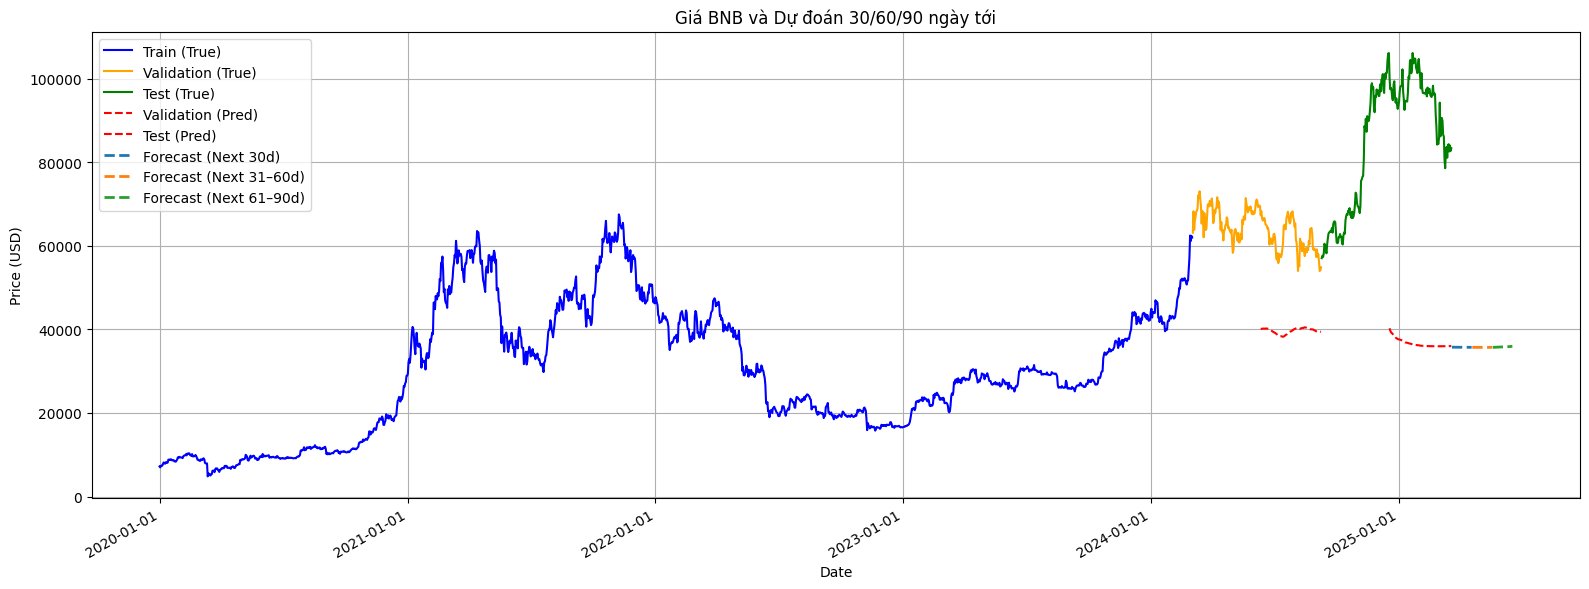

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Tạo ngày cho val/test (do mất time_steps)
dates_val = val_df.index[time_steps:]
dates_test = test_df.index[time_steps:]

plt.figure(figsize=(16, 6))

# --- Vẽ dữ liệu thật ---
plt.plot(train_df.index, train_df['Price'], label='Train (True)', color='blue')
plt.plot(val_df.index, val_df['Price'], label='Validation (True)', color='orange')
plt.plot(test_df.index, test_df['Price'], label='Test (True)', color='green')

# --- Vẽ dự đoán trên val/test ---
plt.plot(dates_val, y_pred_val_original, '--', label='Validation (Pred)', color='red')
plt.plot(dates_test, y_pred_test_original, '--', label='Test (Pred)', color='red')


# Giả sử bạn đã có biến ngày cuối cùng trong tập test
last_date = test_df.index[-1]


# --- Vẽ dự đoán tương lai ---
# Dự đoán 30 ngày
plt.plot(dates_30, pred_30, '--', color='tab:blue', label='Forecast (Next 30d)', linewidth=2)

# Dự đoán ngày 31–60 (chỉ vẽ phần chưa vẽ)
plt.plot(dates_60[30:], pred_60[30:], '--', color='tab:orange', label='Forecast (Next 31–60d)', linewidth=2)

# Dự đoán ngày 61–90 (chỉ vẽ phần chưa vẽ)
plt.plot(dates_90[60:], pred_90[60:], '--', color='tab:green', label='Forecast (Next 61–90d)', linewidth=2)

# --- Định dạng trục ngày ---
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# --- Thêm thông tin biểu đồ ---
plt.title('Giá BNB và Dự đoán 30/60/90 ngày tới')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Biểu đồ thể hiện:


*   Giá thực tế (màu xanh dương + màu vàng): biến động thực tế từ 2020 đến 2025.

* Giá test thực tế (màu xanh lá): đoạn kiểm tra mà mô hình chưa thấy.

* Dự đoán của SVR trên test (đường đỏ): bị trôi thấp, không theo xu hướng tăng/giảm thực tế.

* Dự đoán 30/60/90 ngày tới: đều theo xu hướng giảm → không phản ánh được tín hiệu thị trường thực tế.